# Basic masked dataset with MaskedZarrDataset

Import the "zarrdataset" package

In [1]:
import zarrdataset as zds
import zarr

Load data stored on S3 storage

In [2]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = ["https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.4/idr0073A/9798462.zarr"]

In [3]:
z_img = zarr.open(filenames[0], mode="r")
z_img["0"].info

Name,/0
Type,zarr.core.Array
Data type,uint8
Shape,"(1, 3, 1, 16433, 21115)"
Chunk shape,"(1, 1, 1, 1024, 1024)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,1040948385 (992.7M)
Chunks initialized,0/1071


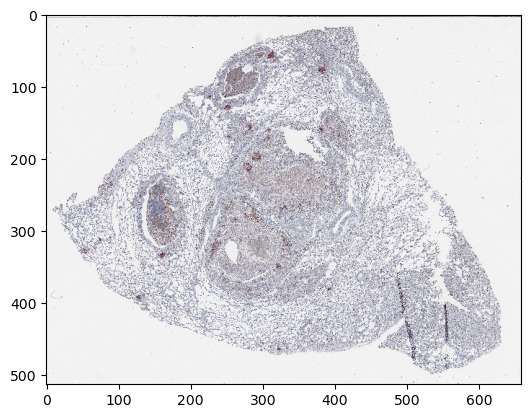

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.moveaxis(z_img["5"][0, :, 0], 0, -1))
plt.show()

Define a mask from where patches can be extracted.

The mask must have the same number of spatial dimensions as the input image.

Because the test image has ZYX axes, this mask also has three axes.

In [5]:
mask = np.array([[
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1],
]], dtype=bool)

ZarrDataset will match the size of the mask t the size of the image that is being sampled.

For that reason, it is not necessary for the mask to be of the same size of the image.

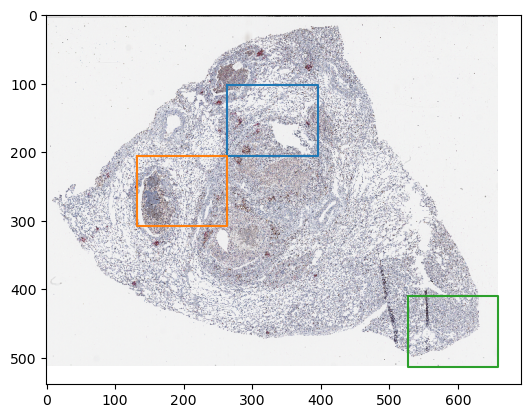

In [6]:
_, d, _, h, w = z_img["5"].shape
m_d, m_h, m_w = mask.shape

factor_d = d / m_d
factor_h = h / m_h
factor_w = w / m_w

plt.imshow(np.moveaxis(z_img["5"][0, :, 0], 0, -1))

sampling_region = np.array([
    [0, 0],
    [0, factor_w],
    [factor_h, factor_w],
    [factor_h, 0],
    [0, 0]
])

for m_z, m_y, m_x in zip(*np.nonzero(mask)):
    offset_y = m_y * factor_h
    offset_x = m_x * factor_w
    plt.plot(sampling_region[:, 1] + offset_x,
             sampling_region[:, 0] + offset_y)

plt.show()

### Extract patches of size 512x512 pixels from a Whole Slide Image (WSI)

Sample the image uniformly in a squared grid pattern

In [7]:
patch_size = dict(Y=512, X=512)
patch_sampler = zds.GridPatchSampler(patch_size=patch_size)

Use the MaskedZarrDataset class to enable extraction of samples from masked regions.

Enable sampling patched from random locations with `shuffle=True`

In [8]:
my_dataset = zds.MaskedZarrDataset(filenames,
                                   data_group="1",
                                   source_axes="TCZYX",
                                   patch_sampler=patch_sampler,
                                   draw_same_chunk=False,
                                   return_any_label=False,
                                   mask_filenames=[mask],
                                   mask_source_axes="ZYX",
                                   mask_axes="ZYX",
                                   mask_data_group="",
                                   shuffle=True)

In [9]:
ds_iterator = iter(my_dataset)

In [10]:
sample = next(ds_iterator)
type(sample), sample.shape, sample.dtype

c:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\boto3\compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


(numpy.ndarray, (1, 3, 1, 1024, 1024), dtype('uint8'))

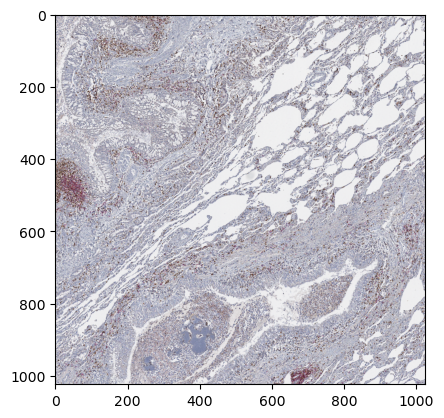

In [11]:
plt.imshow(np.moveaxis(sample[0, :, 0], 0, -1))
plt.show()

In [12]:
np.random.seed(478963)

In [13]:
samples = []
for i, sample in enumerate(my_dataset):
    samples.append(np.pad(np.moveaxis(sample[0, :, 0], 0, -1),((1, 1), (1, 1), (0, 0))))

    # Obtain only 7 samples
    if i >= 9:
        break

grid_samples = np.hstack(samples)

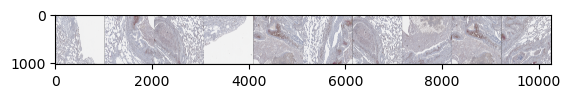

In [14]:
plt.imshow(grid_samples)
plt.show()